In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import utils_x
import xgboost as xgb
from scipy.stats import norm
from utils_x import pos_neg_corr
from utils_x import factor_yhat_corr
from utils_x import train_op
from utils_x import InverseNormalCDF
from utils_x import plot_conditional_expectation
from utils_x import combine_plus
from utils_x import combine_mult
from utils_x import single_train
from utils_x import get_forecast
sns.set(style="darkgrid")
import logging
import time
import itertools
import imp

In [2]:
all_col = ['unique_symbol', 'date_time', 'close', 'turnover', 'open', 'high', 'low', 'volume',\
           "use_tag300", "use_tag500", "use_tag50", "adjustment", "adjustment_cumsum"]

In [3]:
%%time
print("---------------------------------------------------- load and merge -------------------------------------------------------------")
data = pd.read_csv('index500_v2_adjustment.csv', index_col=0)
data["date_time"]  = pd.to_datetime(data["date_time"])
data = data[all_col].copy()
data['wap'] = data['turnover']/data['volume']
data["adjustment"] =  data["adjustment"].fillna(0)


begin_interval_df = pd.read_csv('930_interval.csv', index_col=0)
begin_interval_df["date_time"] = pd.to_datetime(begin_interval_df["date_time"])
index500_df = pd.read_csv('index500_open.csv', index_col=0)
index500_df["date_time"]  = pd.to_datetime(index500_df["date_time"])
index300_df = pd.read_csv('index300_open.csv', index_col=0)
index300_df["date_time"]  = pd.to_datetime(index300_df["date_time"])
index50_df = pd.read_csv('index50_open.csv', index_col=0)
index50_df["date_time"]  = pd.to_datetime(index50_df["date_time"])
future_df = pd.read_csv('future500_open.csv', index_col=0)
future_df["date_time"]  = pd.to_datetime(future_df["date_time"])
market_cap = pd.read_csv('market_cap.csv', index_col=0)
market_cap["date_time"]  = pd.to_datetime(market_cap["date_time"])

data = pd.merge(data, begin_interval_df, how="left", on=['unique_symbol','date_time'])
data = pd.merge(data, market_cap, how="left", on=['unique_symbol','date_time'])
data = pd.merge(data, index500_df, how="left", on=['date_time'])
data = pd.merge(data, index300_df, how="left", on=['date_time'])
data = pd.merge(data, index50_df, how="left", on=['date_time'])
data = pd.merge(data, future_df, how="left", on=['date_time'])

print("------------------------------------------------------ return factor-----------------------------------------------------------------")
gb_unique_symbol = data.groupby(["unique_symbol"])
data["close_y1"] = gb_unique_symbol["close"].transform(lambda x: x.shift(1))
data["open_y1"] = gb_unique_symbol["open"].transform(lambda x: x.shift(1))
data["high_y1"] = gb_unique_symbol["high"].transform(lambda x: x.shift(1))
data["low_y1"] = gb_unique_symbol["low"].transform(lambda x: x.shift(1))
data["wap_y1"] = gb_unique_symbol["wap"].transform(lambda x: x.shift(1))
data["volume_y1"] = gb_unique_symbol["volume"].transform(lambda x: x.shift(1))
data["turnover_y1"] = gb_unique_symbol["turnover"].transform(lambda x: x.shift(1))

data["r_raw"] = (data["close"] -  data["adjustment"])/ data["close_y1"] - 1
data["r_open"] = (data["close"] -  data["adjustment"])/ data["open_y1"] - 1
data["r_high"] = (data["close"] -  data["adjustment"])/ data["high_y1"] - 1
data["r_low"] = (data["close"] -  data["adjustment"])/ data["low_y1"] - 1
data["r_wap"] = (data["close"] -  data["adjustment"])/ data["wap_y1"] - 1
data["r_volume"] = data["volume"] / data["volume_y1"] 
data["r_turnover"] = data["turnover"] / data["turnover_y1"] 

---------------------------------------------------- load and merge -------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


------------------------------------------------------ return factor-----------------------------------------------------------------
CPU times: user 44.9 s, sys: 12.5 s, total: 57.4 s
Wall time: 57.3 s


In [4]:
r_IH = list(data["r_IH"])
r_IF = list(data["r_IF"])
r_IC = list(data["r_IC"])
use_tag50 = list(data["use_tag50"])
use_tag300 = list(data["use_tag300"])
use_tag500 = list(data["use_tag500"])
r_index = []
length = len(data)
for i in range(length):
    if use_tag50[i] == 1:
        r_index.append(r_IH[i])
        continue
    if use_tag300[i] == 1:
        r_index.append(r_IF[i])
        continue
    r_index.append(r_IC[i]) 
data["r_index"] = r_index

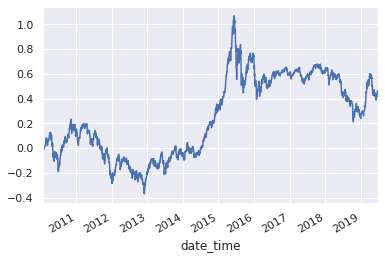

In [5]:
data.groupby(["date_time"])["r_index"].mean().cumsum().plot(label =1)

In [6]:
data["r"] = data["r_raw"] - data["r_index"]
data["square_r"] = data["r_raw"] * data["r_raw"]
data["square_r_raw"] = data["r_raw"] * data["r_raw"]
data["abs_r"] = np.abs(data["r"])
data["abs_r_raw"] = np.abs(data["r_raw"])


print("----------------------------------------------------------- Y --------------------------------------------------------------------")
data["t+1_type"] = gb_unique_symbol["type"].transform(lambda x: x.shift(-1))
data["t+1_open"] = gb_unique_symbol["open"].transform(lambda x: x.shift(-1))
data["t+2_open"] = gb_unique_symbol["open"].transform(lambda x: x.shift(-2))
data['t+2_adjustment'] = gb_unique_symbol["adjustment"].transform(lambda x: x.shift(-2))
data['t+1_adjustment_cumsum'] = gb_unique_symbol['adjustment_cumsum'].transform(lambda x: x.shift(-1))

data["y_open"] = data["t+2_open"] - data['t+2_adjustment']
data['return'] = data['y_open'] / data['t+1_open'] - 1

print("---------------------------------------------------- overnight factor------------------------------------------------------------")
data["limit_tag"] = data["t+1_open"]/data["close"]
data["r1"]  = (data["t+1_930close_mid"] - data["t+1_adjustment_cumsum"] + data["adjustment_cumsum"]) /data["open"] -1

# print("-------------------  EMA r --------------------")
# ema_r_nums = list(range(1,11)) + [0.5, 0.75, 1.25, 1.5, 1.75, 20]
# ema_r_factor = []
# for i in ema_r_nums: 
#     data["r_ema" + str(i)] = gb_unique_symbol["r"].transform(lambda x: x.ewm(halflife = i).mean())
#     ema_r_factor.append("r_ema" + str(i))

print("--------------------------------------------------------- MA rr--------------------------------------------------------------------")
ma_rr_nums = list(range(1,6)) 
ma_rr_factor = []
for i in ma_rr_nums: 
    data["rr_high_ma" + str(i)] = gb_unique_symbol["r_high"].transform(lambda x: x.rolling(i).mean())
    data["rr_low_ma" + str(i)] = gb_unique_symbol["r_low"].transform(lambda x: x.rolling(i).mean())
    data["rr_wap_ma" + str(i)] = gb_unique_symbol["r_wap"].transform(lambda x: x.rolling(i).mean())
    data["rr_open_ma" + str(i)] = gb_unique_symbol["r_open"].transform(lambda x: x.rolling(i).mean())
    ma_rr_factor.append("rr_high_ma" + str(i))
    ma_rr_factor.append("rr_low_ma" + str(i))
    ma_rr_factor.append("rr_wap_ma" + str(i))
    ma_rr_factor.append("rr_open_ma" + str(i))

print("-------------------------------------------------------- MA r_IC------------------------------------------------------------------")
ma_r_ic_nums = list(range(1,11)) 
ma_r_ic_factor = []
for i in ma_r_ic_nums: 
    data["r_IC_ma" + str(i)] = gb_unique_symbol["r_IC"].transform(lambda x: x.rolling(i).mean())
    ma_r_ic_factor.append("r_IC_ma" + str(i))

    
for i in range(1,6): 
    data["abs_r_IC_ma" + str(i)] = gb_unique_symbol["r_IC"].transform(lambda x: np.abs(x).rolling(i).mean())
    
print("-------------------------------------------------------- MA volume ---------------------------------------------------------------")
ma_volume_nums = list(range(1,6)) 
ma_volume_factor = []
data["volume_ma10"] = gb_unique_symbol["r_volume"].transform(lambda x: x.rolling(10).mean())
data["turnover_ma10"] = gb_unique_symbol["r_turnover"].transform(lambda x: x.rolling(10).mean())
for i in ma_volume_nums: 
    data["volume_ma" + str(i)] = gb_unique_symbol["r_volume"].transform(lambda x: x.rolling(i).mean())
    data["volume_s_ma" + str(i)] = data["volume_ma" + str(i)] / (data["volume_ma" + str(i)] + data["volume_ma10"])
    ma_volume_factor.append("volume_s_ma" + str(i))
    data["turnover_ma" + str(i)] = gb_unique_symbol["r_turnover"].transform(lambda x: x.rolling(i).mean())
    data["turnover_s_ma" + str(i)] = data["turnover_ma" + str(i)] / (data["turnover_ma" + str(i)] + data["turnover_ma10"])
    ma_volume_factor.append("turnover_s_ma" + str(i))

print("-------------------------------------------------------- MA r1-----------------------------------------------------------------")
ma_r1_nums = list(range(1,4)) 
ma_r1_factor = []
for i in ma_r1_nums: 
    data["r1_ma" + str(i)] = gb_unique_symbol["r1"].transform(lambda x: x.rolling(i).mean())
    ma_r1_factor.append("r1_ma" + str(i))
print("------------------------------------------------------ MA abs_r_raw--------------------------------------------------------------")
ma_abs_r_raw_nums = list(range(1,16)) + [20, 30]
ma_abs_r_raw_factor = []
for i in ma_abs_r_raw_nums: 
    data["abs_r_raw_ma" + str(i)] = gb_unique_symbol["abs_r_raw"].transform(lambda x: x.rolling(i).mean())
    ma_abs_r_raw_factor.append("abs_r_raw_ma" + str(i))
print("-------------------------------------------------------- MA r_raw----------------------------------------------------------------")
ma_r_raw_nums = list(range(1,16)) + [20, 30]
ma_r_raw_factor = []
for i in ma_r_raw_nums: 
    data["r_raw_ma" + str(i)] = gb_unique_symbol["r_raw"].transform(lambda x: x.rolling(i).mean())
    ma_r_raw_factor.append("r_raw_ma" + str(i))
    
print("---------------------------------------------------------- MA r------------------------------------------------------------------")
ma_r_nums = list(range(1,16)) + [20, 30]
ma_r_factor = []
for i in ma_r_nums: 
    data["r_ma" + str(i)] = gb_unique_symbol["r"].transform(lambda x: x.rolling(i).mean())
    ma_r_factor.append("r_ma" + str(i))

print("------------------------------------------------------- MA turnover------------------------------------------------------------------")
data["Turnover"] = data["turnover"]/data["capital"]
for i in list(range(1,6))+[10]: 
    data["Turnover_ma" + str(i)] = gb_unique_symbol["Turnover"].transform(lambda x: x.rolling(i).mean())
    
# print("------------------- EMA abs_r_raw---------------------")
# ema_abs_r_raw_nums = list(range(1,11)) + [0.5, 0.75, 1.25, 1.5, 1.75, 2.5]
# ema_abs_r_raw_factor = []
# for i in ema_abs_r_raw_nums: 
#     data["abs_r_raw_ema" + str(i)] = gb_unique_symbol["abs_r_raw"].transform(lambda x: x.ewm(halflife = i).mean())
#     ema_abs_r_raw_factor.append("abs_r_raw_ema" + str(i))

# print("------------------- MA square_r_raw---------------------")
# ma_square_r_raw_nums = list(range(1,16)) + [20, 30]
# ma_square_r_raw_factor = []
# for i in ma_square_r_raw_nums: 
#     data["square_r_raw_ma" + str(i)] = gb_unique_symbol["square_r_raw"].transform(lambda x: x.rolling(i).mean())
#     ma_square_r_raw_factor.append("square_r_raw_ma" + str(i))

# print("------------------- MA abs_r---------------------")
# ma_abs_r_nums = list(range(1,16)) + [20, 30]
# ma_abs_r_factor = []
# for i in ma_abs_r_nums: 
#     data["abs_r_ma" + str(i)] = gb_unique_symbol["abs_r"].transform(lambda x: x.rolling(i).mean())
#     ma_abs_r_factor.append("abs_r_ma" + str(i))


----------------------------------------------------------- Y --------------------------------------------------------------------
---------------------------------------------------- overnight factor------------------------------------------------------------
--------------------------------------------------------- MA rr--------------------------------------------------------------------
-------------------------------------------------------- MA r_IC------------------------------------------------------------------
-------------------------------------------------------- MA volume ---------------------------------------------------------------
-------------------------------------------------------- MA r1-----------------------------------------------------------------
------------------------------------------------------ MA abs_r_raw--------------------------------------------------------------
-------------------------------------------------------- MA r_raw----------------------

In [7]:
y_IH = list(data["index50_return"])
y_IF = list(data["index300_return"])
y_IC = list(data["index500_return"])
use_tag50 = list(data["use_tag50"])
use_tag300 = list(data["use_tag300"])
use_tag500 = list(data["use_tag500"])
y_index = []
length = len(data)
for i in range(length):
    if use_tag50[i] == 1:
        y_index.append(y_IH[i])
        continue
    if use_tag300[i] == 1:
        y_index.append(y_IF[i])
        continue
    y_index.append(y_IC[i]) 
data["y_index"] = y_index

In [8]:
print("-------------------------------------------------------- set Universe---------------------------------------------------------------")
data = data[data["t+1_type"]==0].copy()
print("----------------------------------------------------------- label ------------------------------------------------------------------")
gb_date_time = data.groupby(['date_time'])
data['return_std'] = gb_date_time["return"].transform(lambda x: x.std())
data["return_deindex"] = data["return"] - data["y_index"]
data['label'] = data["return_deindex"]/data['return_std']
data['mr'] = gb_date_time["return"].transform(lambda x: x.mean())

data["cont"] = gb_date_time["unique_symbol"].transform(lambda x: x.count())
data["cont"] = data["cont"] + 1
data["r_raw_uniform"] = gb_date_time["r_raw"].transform(lambda x: x.rank())
data["r_raw_uniform"] = data["r_raw_uniform"] / data["cont"]
print(data["label"].mean()) 
data = data[~data['label'].isnull()].copy()
print(data["label"].mean())

print("--------------------------------------------------------- add factor ---------------------------------------------------------------")
gb_unique_symbol =  data.groupby(['unique_symbol'])
gb_date_time =  data.groupby(['date_time'])
ma_uniform_nums = list(range(1,6))
ma_uniform_factor = []
for i in ma_uniform_nums: 
    data["uniform_ma" + str(i)] = gb_unique_symbol["r_raw_uniform"].transform(lambda x: x.rolling(i).mean())
    ma_uniform_factor.append("uniform_ma" + str(i))
        
data["r1_distribute"] = gb_date_time["r1"].transform(lambda x: (x-x.mean())/x.std())

data["turnover_rank"] = gb_date_time['turnover'].transform( lambda x:x.rank())
data["turnover_norm"] = data["turnover_rank"] / data["cont"]
data["turnover_norm"] = data["turnover_norm"].apply(lambda x: InverseNormalCDF(x))

data["volume_rank"] = gb_date_time['volume'].transform( lambda x:x.rank())
data["volume_norm"] = data["volume_rank"] / data["cont"]
data["volume_norm"] = data["volume_norm"].apply(lambda x: InverseNormalCDF(x))

data["close_rank"] = gb_date_time['close'].transform( lambda x:x.rank())
data["close_norm"] = data["close_rank"] / data["cont"]
data["close_norm"] = data["close_norm"].apply(lambda x: InverseNormalCDF(x))

data["r"] = data["close"]/ data["open"] - 1
data["r_distribute"] = gb_date_time["r"].transform(lambda x: (x-x.mean())/x.std())
data["amplitude_ratio"] =  abs((data["close"] - data["open"])/(data["high"] - data["low"]))
data["amplitude_ratio"] = data["amplitude_ratio"].fillna(0)
data["amplitude"] = (data["high"] - data["low"]) / data["close"]

data["std"] = gb_date_time["return_std"].transform(lambda x: x.shift(1))
data["std_ma2"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(2).mean())
data["std_ma3"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(3).mean())
data["std_ma4"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(4).mean())
data["std_ma5"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(5).mean())
data["std_ma6"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(6).mean())
data["std_ma7"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(7).mean())
data["std_ma8"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(8).mean())
data["std_ma10"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(10).mean())
data["std_ma15"] = gb_unique_symbol["std"].transform(lambda x: x.rolling(15).mean())

-------------------------------------------------------- set Universe---------------------------------------------------------------
----------------------------------------------------------- label ------------------------------------------------------------------
0.011176004652351784
0.011176004652351804
--------------------------------------------------------- add factor ---------------------------------------------------------------


In [ ]:
data.groupby(["date_time"])["return_std"].mean().rolling(30).mean().plot(label =4)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
data.groupby(["date_time"])["return"].std().rolling(130).mean().plot(label =1)
data.groupby(["date_time"])["return"].mean().rolling(130).std().plot(label =4)
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
data.groupby(["date_time"])["turnover_s_ma1"].std().rolling(1).mean().plot(label =1)
data.groupby(["date_time"])["turnover_s_ma1"].std().rolling(10).mean().plot(label =2)
data.groupby(["date_time"])["turnover_s_ma1"].std().ewm(halflife =30).mean().plot(label =3)
data.groupby(["date_time"])["turnover_s_ma1"].mean().rolling(30).mean().plot(label =4)
plt.legend()

In [ ]:
# base = [["r_raw_ma1", "r_raw_ma2", "r_raw_ma3", "r_raw_ma4", "r_raw_ma5", "r_raw_ma7", "r_raw_ma20",
#         "r_ma1","r_ma2","r_ma3","r_ma6","r_ma9",'abs_r_raw_ma1','abs_r_raw_ma3','abs_r_raw_ma4','abs_r_raw_ma5']]
# add1 = list(itertools.combinations(ma_abs_r_raw_factor, 1))
# add1 = [list(i) for i in add1]
# factor_group_l = combine_mult(base, add1)
# print(len(factor_group_l))
# factor_group_l

In [9]:
use_f = []
use_f1 = ["r_raw_ma1", "r_raw_ma2", "r_raw_ma3", "r_raw_ma4", "r_raw_ma5","r_raw_ma7", "r_raw_ma20"]
use_f2 = ["r_ma1", "r_ma2","r_ma3", "r_ma6", "r_ma9",]
use_f3 = ["abs_r_raw_ma1", "abs_r_raw_ma3", "abs_r_raw_ma4", "abs_r_raw_ma5", "abs_r_raw_ma10"]
use_f4 = ["r1", "r1_ma2", "r1_distribute"]
use_f5 = ["r_IC_ma1", "r_IC_ma5", "r_IC_ma7"] + ma_rr_factor
use_f6 = ["close_norm", "volume_norm", "turnover_norm"]
use_f7 = ma_volume_factor
use_f8 = ["r", "r_distribute", "amplitude", "amplitude_ratio"]
use_f9 = ["Turnover_ma1", "Turnover_ma2", "Turnover_ma3", "Turnover_ma4", "Turnover_ma5", "Turnover_ma10"]
use_f = use_f + use_f1 + use_f2 + use_f3 + use_f5 + use_f6 + use_f7 + use_f8 + use_f9
use_f = use_f + use_f4
# use_f = use_f + ["abs_r_IC_ma1","abs_r_IC_ma2","abs_r_IC_ma3","abs_r_IC_ma4","abs_r_IC_ma5"]
use_f = use_f + ["std", "std_ma2", "std_ma3", "std_ma4", "std_ma5"]

In [ ]:
# gb = data.groupby(["date_time"])
# need_deVolatility = use_f8  
# for f in need_deVolatility:
#     print(f)
#     data["temp_std"] = gb[f].transform(lambda x : x.std())
#     data["temp_std"] = gb["temp_std"].transform(lambda x: x.ewm(halflife = 5).mean()) 
#     data[f] = data[f]/data["temp_std"]

In [10]:
# 批量训练
print(len(use_f))
imp.reload(logging)
t1 = datetime.datetime(2010,1,1)
t2 = datetime.datetime(2014,6,1)
t3 = datetime.datetime(2015,6,1)
t4 = datetime.datetime(2019,7,1)


params = {
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'alpha': 100,
            "nthread": 20,
            "num_parallel_tree":10,
            "tree_method": 'gpu_hist',
            "gpu_id":0,
#             "max_bin":64
#             "min_child_weight": 1000
        }
print(params)
early = 30
num_rounds = 200
split_type = "random"
imp.reload(utils_x)
bst = utils_x.single_train(data, use_f, t1, t2, t3, t4, params, early, num_rounds, split_type)

{'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha': 100, 'nthread': 20, 'num_parallel_tree': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
factor:r_raw_ma1|r_raw_ma2|r_raw_ma3|r_raw_ma4|r_raw_ma5|r_raw_ma7|r_raw_ma20|r_ma1|r_ma2|r_ma3|r_ma6|r_ma9|abs_r_raw_ma1|abs_r_raw_ma3|abs_r_raw_ma4|abs_r_raw_ma5|abs_r_raw_ma10|r_IC_ma1|r_IC_ma5|r_IC_ma7|rr_high_ma1|rr_low_ma1|rr_wap_ma1|rr_open_ma1|rr_high_ma2|rr_low_ma2|rr_wap_ma2|rr_open_ma2|rr_high_ma3|rr_low_ma3|rr_wap_ma3|rr_open_ma3|rr_high_ma4|rr_low_ma4|rr_wap_ma4|rr_open_ma4|rr_high_ma5|rr_low_ma5|rr_wap_ma5|rr_open_ma5|close_norm|volume_norm|turnover_norm|volume_s_ma1|turnover_s_ma1|volume_s_ma2|turnover_s_ma2|volume_s_ma3|turnover_s_ma3|volume_s_ma4|turnover_s_ma4|volume_s_ma5|turnover_s_ma5|r|r_distribute|amplitude|amplitude_ratio|Turnover_ma1|Turnover_ma2|Turnover_ma3|Turnover_ma4|Turnover_ma5|Turnover_ma10|r1|r1_ma2|r1_distribute|std|std_ma2|std_ma3|std_ma4|std_ma5


71
{'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha': 100, 'nthread': 20, 'num_parallel_tree': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
-------------------- train -----------------------
[0]	train-rmse:1.05514	eval-rmse:1.05382
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 30 rounds.
[1]	train-rmse:1.02595	eval-rmse:1.02491
[2]	train-rmse:1.01069	eval-rmse:1.01004
[3]	train-rmse:1.00272	eval-rmse:1.00225
[4]	train-rmse:0.99832	eval-rmse:0.99802
[5]	train-rmse:0.99570	eval-rmse:0.99542
[6]	train-rmse:0.99415	eval-rmse:0.99393
[7]	train-rmse:0.99307	eval-rmse:0.99284
[8]	train-rmse:0.99221	eval-rmse:0.99197
[9]	train-rmse:0.99160	eval-rmse:0.99138
[10]	train-rmse:0.99107	eval-rmse:0.99092
[11]	train-rmse:0.99059	eval-rmse:0.99049
[12]	train-rmse:0.99009	eval-rmse:0.99004
[13]	train-rmse:0.98967	eval-rmse:0.98960
[14]	train-rmse:0.98925	eval-rmse:0.98922
[15]	train-rmse:0.98884	eval-

[185]	train-rmse:0.96253	eval-rmse:0.97150
[186]	train-rmse:0.96244	eval-rmse:0.97145
[187]	train-rmse:0.96232	eval-rmse:0.97142
[188]	train-rmse:0.96222	eval-rmse:0.97138
[189]	train-rmse:0.96213	eval-rmse:0.97134
[190]	train-rmse:0.96205	eval-rmse:0.97132
[191]	train-rmse:0.96197	eval-rmse:0.97127
[192]	train-rmse:0.96187	eval-rmse:0.97122
[193]	train-rmse:0.96179	eval-rmse:0.97119
[194]	train-rmse:0.96172	eval-rmse:0.97115
[195]	train-rmse:0.96163	eval-rmse:0.97110
[196]	train-rmse:0.96155	eval-rmse:0.97105
[197]	train-rmse:0.96146	eval-rmse:0.97102
[198]	train-rmse:0.96138	eval-rmse:0.97099
[199]	train-rmse:0.96130	eval-rmse:0.97095



test_set2015:0.13689355339824555
test_set2016:0.1539703256591623
test_set2017:0.1308334142867283
test_set2018:0.1103763493363885
test_set2019:0.08336113849332766
test_all_corrcoef:0.12283141017480001
test_all_corrcoef_Nodemean:0.12710117513147634


val_set2014:0.20042231968680707
val_set2015:0.2946086178103875
val__all_corrcoef:0.23037345068208345
val__all_corrcoef_Nodemean:0.26510945716915674


train_set2010:0.31293886324678644
train_set2011:0.28271422600885737
train_set2012:0.2773489029832574
train_set2013:0.28106939618334686
train_set2014:0.2678017112933097
train_corrcoef:0.2909816006661733
train_corrcoef_Nodemean:0.3074564448883593

tree_nums:2000
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-pa

In [ ]:
tb = datetime.datetime(2018,5,27)
te = datetime.datetime(2018,6,12)
imp.reload(utils_x)
utils_x.pos_neg_corr(data, use_f, tb, te, bst)

0.12921862674070966


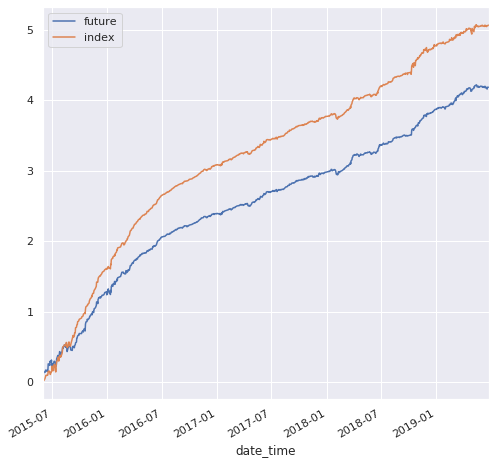

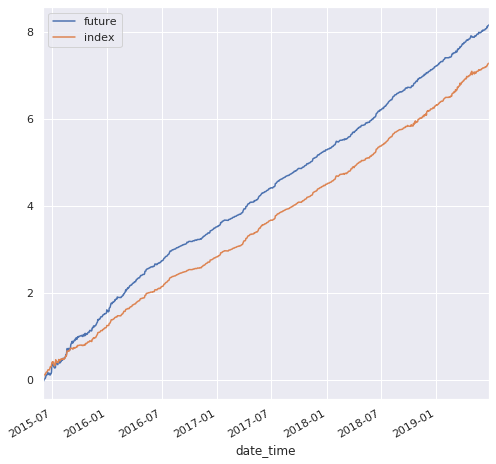

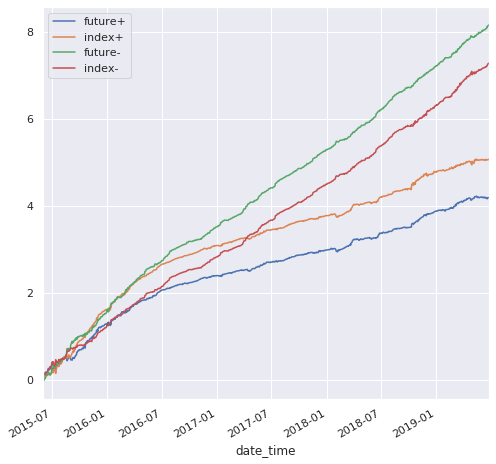

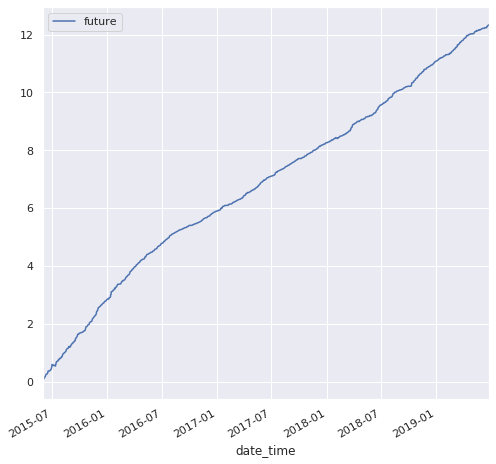

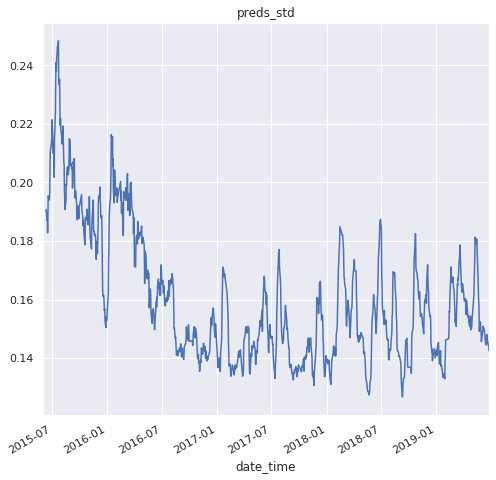

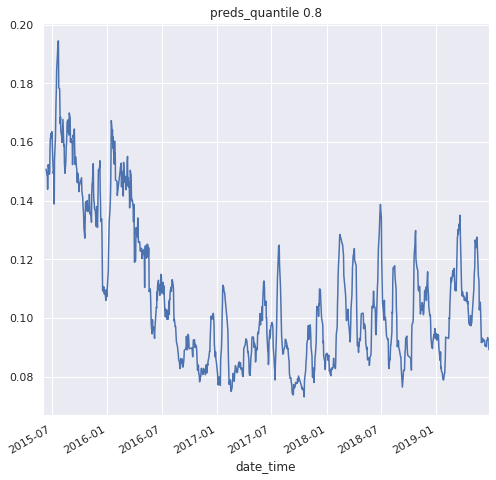

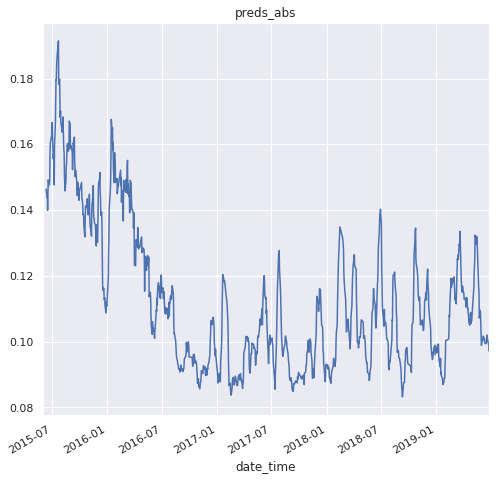

In [11]:
tb = datetime.datetime(2015,6,1)
te = datetime.datetime(2019,7,1)
imp.reload(utils_x)
data_sim = utils_x.pnl_plot(tb, te, data, use_f, bst)

In [ ]:
tb = datetime.datetime(2018,1,1)
te = datetime.datetime(2018,12,12)
p1 = data_sim[(data_sim
               ["date_time"]>=tb) & (data_sim["date_time"]<=te)].sort_values(by=["preds"], ascending=False)

In [ ]:
len(p1)/50

In [ ]:
p1[["date_time", "unique_symbol", "return", "preds", "limit_tag"]].head(720)["return"].mean()

In [ ]:
p1.head(720)["y_index"].mean()

In [ ]:
p1.head(720)["mr"].mean()

In [ ]:
p1.head(720)["future500_return"].mean()

In [ ]:
p1["return"].mean()

In [ ]:
p1["y_index"].mean()

In [ ]:
p1["future500_return"].mean()

In [ ]:
pp = data_sim[data_sim["date_time"].dt.year == 2019].sort_values(by=["preds"], ascending=False)
pp[["date_time", "unique_symbol", "return", "preds", "limit_tag", "t+1_open", "t+2_open", "t+2_adjustment"]].head(50)

In [ ]:
factor_yhat_corr(bst, data, use_f, t1, t3)

In [ ]:
# 单次训练分析
early = 30
t1 = datetime.datetime(2010,1,1)
t2 = datetime.datetime(2014,6,1)
t3 = datetime.datetime(2015,6,1)
t4 = datetime.datetime(2018,1,1)
data_tr = data[ (data["date_time"] >= t1) & (data["date_time"] < t2)].copy()
data_te = data[ (data["date_time"] >= t2) & (data["date_time"] < t3)].copy()
data_fin = data[ (data["date_time"] >= t3) & (data["date_time"] < t4)].copy()

In [ ]:
data_fin = utils_x.get_preds(data_fin, use_f, bst)

In [ ]:
data_fin.loc[2842905:,["r1","date_time","unique_symbol","preds","close","return","label","t+1_open", "t+2_open", "limit_tag"]]

In [ ]:
data_fin[data_fin["limit_tag"]>1.099]

In [ ]:
df_tree = bst.trees_to_dataframe()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.tick_params(labelsize=12)
f_importance_bar(importance_dic)

In [ ]:
import shap
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(data_tr[use_f])
shap.summary_plot(shap_values, data[use_f], plot_type="bar")

In [ ]:
all_tree_rounds = bst.best_ntree_limit + early
tr_step = []
te_step = []
fin_step = []
for i in range(1, all_tree_rounds):
    if i % 5==0:
        print("Tree numbers：" ,i ,"best_ntree_limit:", bst.best_ntree_limit, "early_stop:", early)
    temp1 = bst.predict( xgb.DMatrix(data_tr[use_f]),ntree_limit= i)
    temp2 = bst.predict( xgb.DMatrix(data_te[use_f]),ntree_limit= i)
    temp3 = bst.predict( xgb.DMatrix(data_fin[use_f]),ntree_limit= i)
    corrcoef1 = np.corrcoef(temp1, data_tr["return"] - data_tr["mr"])[0,1]
    corrcoef2 = np.corrcoef(temp2, data_te["return"] - data_te["mr"])[0,1]
    corrcoef3 = np.corrcoef(temp3, data_fin["return"] - data_fin["mr"])[0,1]
    tr_rmse = ((temp1 - data_tr["label"])*(temp1 - data_tr["label"])).mean()
    te_rmse = ((temp2 - data_te["label"])*(temp2 - data_te["label"])).mean()
    fin_rmse = ((temp3 - data_fin["label"])*(temp3 - data_fin["label"])).mean()
    tr_step.append([tr_rmse, corrcoef1])
    te_step.append([te_rmse, corrcoef2])
    fin_step.append([fin_rmse, corrcoef3])

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(np.array(tr_step)[:,0], label="Train")
plt.plot(np.array(te_step)[:,0], label="Val")
plt.plot(np.array(fin_step)[:,0], label="Test")
plt.xlabel("Tree Numbers")
plt.ylabel("RMSE")
plt.vlines(bst.best_ntree_limit, 0.94, 1, colors = "c", linestyles = "dashed")
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(np.array(tr_step)[:,1], label="Train")
plt.plot(np.array(te_step)[:,1], label="Val")
plt.plot(np.array(fin_step)[:,1], label="Test")
plt.xlabel("Tree Numbers")
plt.ylabel("Corr")
plt.vlines(bst.best_ntree_limit, 0.05, 0.25, colors = "c", linestyles = "dashed")
plt.legend()

In [ ]:
all_tree_rounds = bst.best_ntree_limit + early
zero = []
leave_node = []
tree_node = []
for tree_id in range(1, all_tree_rounds):
    zero.append(df_tree[(df_tree["Tree"] == tree_id)  & (df_tree["Feature"] == "Leaf") & (df_tree["Gain"] == 0)].shape[0])
    leave_node.append(df_tree[(df_tree["Tree"] == tree_id)  & (df_tree["Feature"] == "Leaf")].shape[0])
    tree_node.append(df_tree[(df_tree["Tree"] == tree_id)].shape[0])

In [ ]:
zero = np.array(zero)
plt.rcParams['figure.figsize'] = (6, 6)
leave_node = np.array(leave_node)
tree_node = np.array(tree_node)
plt.vlines(bst.best_ntree_limit, 0.35, 0.65, colors = "r", linestyles = "dashed")
plt.xlabel("Tree Numbers")
plt.ylabel("z_ratio(zero_leave / leave)")
zr = np.mean(zero/leave_node)
plt.text(10, 0.65, r"z_ratio mean: %.2f" %(zr) , fontsize=15)
plt.plot(zero/leave_node)

In [ ]:
plt.rcParams['figure.figsize'] = (6, 6)
plt.text(20, 120, r"Average leave_node: %.2f" %(np.mean(leave_node)) , fontsize=15)
plt.xlabel("Tree Numbers")
plt.ylabel("Leave_Node Nums")
plt.plot(tree_node)
plt.vlines(bst.best_ntree_limit, 50, 120, colors = "r", linestyles = "dashed")

In [ ]:
tb = datetime.datetime(2015,6,1)
te = datetime.datetime(2018,1,1)
data_sim = data[ (data["date_time"] >= tb) & (data["date_time"] < te)]
sim_pred =  bst.predict(xgb.DMatrix(data_sim[use_f]), ntree_limit= bst.best_ntree_limit)
data_sim["preds"] = sim_pred

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
data_sim["preds"].hist(bins= 100)

In [ ]:
data_sim = data_sim.reset_index(drop=True)
gb = data_sim.groupby(['date_time'])['preds']
data_sim["pred_mean"] = gb.transform(lambda x: x.mean())
data_sim["preds"] = data_sim["preds"] - data_sim["pred_mean"]

In [ ]:
np.corrcoef(data_sim["preds"], data_sim["return"] - data_sim["mr"])[0,1]

In [ ]:
data_sim["preds"].hist(bins= 100)

In [ ]:
data_sim["preds+"] = data_sim["preds"].apply(lambda x: x if x>=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["future500_return"])
data_sim["pnl_byweightI1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
pnl_byweightF1 = data_sim.groupby(['date_time'])['pnl_byweightF1'].sum()*0.008
pnl_byweightI1 = data_sim.groupby(['date_time'])['pnl_byweightI1'].sum()*0.008
pnl_byweightF1.cumsum().plot(label = "future")
pnl_byweightI1.cumsum().plot(label = "index")
plt.legend()

In [ ]:
data_sim["preds-"] = data_sim["preds"].apply(lambda x: x if x<=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightI2"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
data_sim["pnl_byweightF2"] =  data_sim["preds-"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF2 = data_sim.groupby(['date_time'])['pnl_byweightF2'].sum()*0.008
pnl_byweightI2 = data_sim.groupby(['date_time'])['pnl_byweightI2'].sum()*0.008
pnl_byweightF2.cumsum().plot(label = "future")
pnl_byweightI2.cumsum().plot(label = "index")
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF"] = data_sim["preds"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF = data_sim.groupby(['date_time'])['pnl_byweightF'].sum()*0.008
pnl_byweightF.cumsum().plot(label = "future")
plt.legend()

In [ ]:
gb = data_sim.groupby(["unique_symbol"])
data_sim["yesterday_preds"] = gb["preds"].shift(1)
data_sim["preds"] = data_sim.apply(lambda x: min(x["preds"], x["yesterday_preds"]) if x["r1"] >= 0.099 else x["preds"], axis=1)
data_sim["preds"] = data_sim.apply(lambda x: max(x["preds"], x["yesterday_preds"]) if x["r1"] <= -0.099 else x["preds"], axis=1)

In [ ]:
data_sim["preds+"] = data_sim["preds"].apply(lambda x: x if x>=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["future500_return"])
data_sim["pnl_byweightI1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
pnl_byweightF1 = data_sim.groupby(['date_time'])['pnl_byweightF1'].sum()*0.008
pnl_byweightI1 = data_sim.groupby(['date_time'])['pnl_byweightI1'].sum()*0.008
pnl_byweightF1.cumsum().plot(label = "future")
pnl_byweightI1.cumsum().plot(label = "index")
plt.legend()

In [ ]:
data_sim["preds-"] = data_sim["preds"].apply(lambda x: x if x<=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightI2"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
data_sim["pnl_byweightF2"] =  data_sim["preds-"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF2 = data_sim.groupby(['date_time'])['pnl_byweightF2'].sum()*0.008
pnl_byweightI2 = data_sim.groupby(['date_time'])['pnl_byweightI2'].sum()*0.008
pnl_byweightF2.cumsum().plot(label = "future")
pnl_byweightI2.cumsum().plot(label = "index")
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF"] = data_sim["preds"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF = data_sim.groupby(['date_time'])['pnl_byweightF'].sum()*0.008
pnl_byweightF.cumsum().plot(label = "future")
plt.legend()

## **生成sim所需要的forecast文件**

In [24]:
sim_df = data_sim[["date_time","preds","unique_symbol"]].copy()
imp.reload(utils_x)
forecast_df, forecast = utils_x.get_forecast(sim_df)

0 2737538
5000 2737538
10000 2737538
15000 2737538
20000 2737538
25000 2737538
30000 2737538
35000 2737538
40000 2737538
45000 2737538
50000 2737538
55000 2737538
60000 2737538
65000 2737538
70000 2737538
75000 2737538
80000 2737538
85000 2737538
90000 2737538
95000 2737538
100000 2737538
105000 2737538
110000 2737538
115000 2737538
120000 2737538
125000 2737538
130000 2737538
135000 2737538
140000 2737538
145000 2737538
150000 2737538
155000 2737538
160000 2737538
165000 2737538
170000 2737538
175000 2737538
180000 2737538
185000 2737538
190000 2737538
195000 2737538
200000 2737538
205000 2737538
210000 2737538
215000 2737538
220000 2737538
225000 2737538
230000 2737538
235000 2737538
240000 2737538
245000 2737538
250000 2737538
255000 2737538
260000 2737538
265000 2737538
270000 2737538
275000 2737538
280000 2737538
285000 2737538
290000 2737538
295000 2737538
300000 2737538
305000 2737538
310000 2737538
315000 2737538
320000 2737538
325000 2737538
330000 2737538
335000 2737538
34000

2635000 2737538
2640000 2737538
2645000 2737538
2650000 2737538
2655000 2737538
2660000 2737538
2665000 2737538
2670000 2737538
2675000 2737538
2680000 2737538
2685000 2737538
2690000 2737538
2695000 2737538
2700000 2737538
2705000 2737538
2710000 2737538
2715000 2737538
2720000 2737538
2725000 2737538
2730000 2737538
2735000 2737538


In [ ]:
data_sim["preds"].hist(bins =100)

In [ ]:
sim_df = data_sim[["date_time","return","unique_symbol"]].copy()
imp.reload(utils_x)
forecast_df, forecast = utils_x.get_return(sim_df)

In [ ]:
plt.plot(forecast.sum(axis =0))

In [ ]:
df = pd.read_csv('/home/huandong/sim_data/forecast.csv', header=None)

In [ ]:
r_df = pd.read_csv('/home/huandong/sim_data/return.csv', header=None)

In [ ]:
abs_df = abs(df)

In [ ]:
pos_df = (abs_df + df)/2

In [ ]:
(pos_df*r_df).mean(axis=1).cumsum().plot()

In [ ]:
pos_df.sum()